# Uniper Account Classification

In [1]:
! pip install python-docx

     |████████████████████████████████| 5.6 MB 14.0 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184507 sha256=c7599ee9b2309fcf591945ea264b659fcfdf0c6beb8414f38ea6d9d17a0e0b14
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import zipfile
from zipfile import ZipFile
from pathlib import Path
from typing import Dict, Optional, List, Sequence, Tuple, Any
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from docx import Document
import matplotlib.pyplot as plt
import dill as pkl  # dill is used because pickle cannot handle lambda functions
import pickle
from datetime import date
from pathlib import Path
import zipfile
from zipfile import ZipFile
import dill as pkl
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import json
%matplotlib inline

TODAY = date.today().strftime("%Y%m%d")
CLIENT = "Uniper"
MIN_NUM_OF_SAMPLES = 5
COUNTRY = 'DE'  # possible choices: DE, UK, AT, SE, UBX
SAVE_CLFS = True
PREDICTIONS_EXCEL = False
RES_DIR = Path(f"./retraining_october21/{COUNTRY.lower()}")
SCAN_ID_COL = "gl_document_scan_id"  # document identifier col used when reducing
                                     # global df to relevant examples for attribute

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

In [6]:
# %load training_utils.py
"""This file contains helper functionality to train/evaluate models
   and create reports"""

import zipfile
from zipfile import ZipFile
from pathlib import Path
from typing import Dict, Optional, List, Sequence, Tuple, Any
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from docx import Document
import matplotlib.pyplot as plt
import dill as pkl  # dill is used because pickle cannot handle lambda functions


def reduce_to_relevant(df: DataFrame, col: str, min_num_samples: int) -> DataFrame:
    """Reduces df to instances with values in col that appear at least
       min_num_samples times and returns reduced df.

    Args:
        df (DataFrame): Input DataFrame.
        col (str): Name of the column that holds the feature of interest.
        min_num_samples (int): Minimum number of times a value has to appear
            in column 'col'.

    Returns:
        DataFrame: Reduced DataFrame containing only those values in 'col'
            that appear more than 'min_num_samples' times.

    """
    # find rows for values that appear at least min_num_samples times
    relevant = [x for x in df[col].value_counts().index
                if df[col].value_counts()[x] >= min_num_samples]
    # create boolean mask
    mask = [(x in relevant) for x in df[col]]

    print(
        f"Reduced to {len(df[mask])} samples from {len(relevant)} relevant classes. (N={min_num_samples})"
    )

    return df[mask]


def get_reduced_df(
        df: DataFrame,
        feature_col: str,
        scan_id_col: str,
        min_num_samples: int) -> DataFrame:
    """Drops duplicates and reduces df to relevant examples that appear
       at least min_num_samples times and are unambiguous.

    Args:
        df (DataFrame): Input DataFrame.
        feature_col (str): Name of the column that holds the feature of interest.
        scan_id_col (str): Name of the column that holds the unique
            document identifier.
        min_num_samples (int): Minimum number of times a value has to appear
            in column 'feature_col'.

    Returns:
        DataFrame: Reduced DataFrame containing only those values in 'feature_col'
            that appear more than 'min_num_samples' times and are unambiguous.

    """
    # keep only documents with unambiguous value for this col
    df_ = df.drop_duplicates(subset=[scan_id_col, feature_col])\
            .groupby(scan_id_col)\
            .filter(lambda x: len(x) == 1)

    return reduce_to_relevant(df_, feature_col, min_num_samples)


def split_for_target_col(df, col, test_size=0.2, random_state=666):
    """
    Performs train test split with specified col as target variable.
    Returns: X_train, X_test, y_train, y_test
    """
    return train_test_split(
        df,
        df[col],
        test_size=test_size,
        random_state=random_state
    )


def _get_top_n_results_with_confs(
        clazzes: Sequence[str],
        probs: List[float],
        n: int = 1) -> List[Tuple[str, float]]:
    """Constructs list of (class, proba) tuples for top n results.

    Args:
        clazzes (Sequence[str]): Sequence of class names as stored in
            clf.classes_ attribute of sklearn classifier.
        probs (List[float]): List with probabilities for each class in clazzes.
        n (int): Number of most probable results to return. Defaults to 1.

    Returns:
        List[Tuple[str, float]]: List of (class, proba) tuples for top n results.

    """
    return sorted(
        zip(clazzes, probs),
        key=lambda x: x[1],
        reverse=True
    )[:n]


def get_results_for_target(
        target_clf: Any,
        df: DataFrame) -> List[Tuple[str, float]]:
    """Computes predictions with provided classifier on DataFrame df.

    Args:
        target_clf (Any): Sklearn classifier that offers 'predict_proba()'.
        df (DataFrame): Input DataFrame as expected by 'target_clf'.

    Returns:
        List[Tuple[str, float]]: List of (class, proba) tuples for
            instances in df.

    """
    probs = target_clf.predict_proba(df)
    clazzes = target_clf.classes_
    results = []
    for prob_list in probs:
        results.append(_get_top_n_results_with_confs(clazzes, prob_list)[0])
    return results


def _get_text_col_from_df(df: DataFrame):
    return df['text']


def save_clf_to_disk(
        clf,
        attribute_name: str,
        folder: Path,
        date: str,
        client: str,
        country: str,
        min_num_samples: int,
        add_zip=True) -> None:

    # safe to pkl with full info in file name
    pkl_path = folder / f"{date}_{client}_clf_{attribute_name}_{country.lower()}_N_{min_num_samples}.pkl"
    with open(pkl_path, 'wb') as file:
        pkl.dump(clf, file)

    if add_zip:
        # create zip with non changing name for easy deployment
        zip_path = folder / f"clf_{attribute_name}_{country.lower()}_N_{min_num_samples}.pkl.zip"
        with ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as file:
            # second argument avoids recreation of folder structure in zip-archive
            file.write(pkl_path, pkl_path.parts[-1])


def enrich_kw_list(kw_list):
    """Enriches keywords by replacing street names with possible synonyms. Since we demand ALL keywords to
       be found for a positive match, this function returns a list of keyword lists, one for every possible
       synonym.
    
    """
    new_kw_lists = [kw_list]
    street_synonyms = ["str.", "strasse", "straße"]
    for street_syn in street_synonyms:
        remaining_syns = [x for x in street_synonyms if x != street_syn]
        if any(street_syn in kw for kw in kw_list):
            new_kw_lists += [[kw.replace(street_syn, synonym) for kw in kw_list] for synonym in remaining_syns]
    return new_kw_lists


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
tday = date.today().strftime("%A %d. %B %Y") 
print(f"Models trained on {tday} with package versions: \n")
print(f"scikit-learn: {sklearn.__version__}")
print(f"dill: {pkl.__version__}")

Models trained on Sunday 06. February 2022 with package versions: 

scikit-learn: 1.0.2
dill: 0.3.4


In [9]:
# dicts used to restrict ground truth later
country_group_to_countries = {
    "DE": ["DE"],
    "SE": ["SE"],
    "AT": ["AT"],
    "UK": ["GB"],
    "UBX": ["BE", "NL", "LU"]    
}

In [10]:
pickle_texts = "/content/drive/MyDrive/KPMG/Multiple_Classification/texts_all_rt202110.pkl"
uniper =  "/content/drive/MyDrive/KPMG/Multiple_Classification/Uniper_GT_09_21.xlsx"
sc21_json = "/content/drive/MyDrive/KPMG/Multiple_Classification/sc21v8.json"

with open(pickle_texts, "rb") as file:
    df_lume = pickle.load(file)
df_lume.drop_duplicates(inplace=True)
print(df_lume.shape)

df_ground_truth = pd.read_excel(uniper)
len(df_ground_truth)

df_ground_truth.dropna(subset=[SCAN_ID_COL], inplace=True)
df_ground_truth[SCAN_ID_COL] = df_ground_truth[SCAN_ID_COL].apply(lambda x: x.lower())

len(df_ground_truth[SCAN_ID_COL].unique())
df_merged = df_lume.merge(df_ground_truth, left_on=["filename"], right_on=[SCAN_ID_COL], how="inner")

df_merged.drop_duplicates(inplace=True)
df_merged.shape

# add left-hand zeros to gl_legal_entity_id, gl_accounts_id, gl_vendor_id
df_merged['gl_legal_entity_id'] = df_merged['gl_legal_entity_id'].apply(lambda x: str(int(x)).zfill(4))
df_merged['gl_accounts_id'] = df_merged['gl_accounts_id'].apply(lambda x: str(int(x)).zfill(10))
df_merged['gl_vendor_id'] = df_merged['gl_vendor_id'].apply(lambda x: str(int(x)).zfill(10))

# restict to respective country(group)
df = df_merged[
    df_merged['le_country_id'].isin(country_group_to_countries[COUNTRY])
]

df['le_country_id'].value_counts()

df['gl_posting_id'] = df['gl_posting_id'].apply(lambda x: str(int(x)))

dft = get_reduced_df(df, 'gl_posting_id', SCAN_ID_COL, MIN_NUM_OF_SAMPLES)
dft[dft['gl_posting_id'] == '50']
df[['gl_legal_entity_id', 'gl_accounts_id', 'gl_cost_center_id', 'gl_wbs_element_id', 'gl_vendor_id']]

(160704, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Reduced to 32962 samples from 3 relevant classes. (N=5)


,gl_legal_entity_id,gl_accounts_id,gl_cost_center_id,gl_wbs_element_id,gl_vendor_id
0,0037,1734082001,0000037001,NaN,0002000582
1,0037,1734934025,0000037001,NaN,0002449868
2,0037,1734067004,0000037001,NaN,0002053354
3,0037,1734934001,0000037001,NaN,0001000092
4,0037,1734030000,0000037001,NaN,0001257969
...,...,...,...,...,...
90275,9370,1734999000,2937052000,NaN,0002006228
90276,9370,1734940001,2937060000,NaN,0001435553
90277,9370,1734934012,2937039200,NaN,0002037197
90278,9370,1734950002,2937059000,NaN,0002479202


In [11]:
with open(sc21_json, 'r') as file:
    mapping_json = json.load(file)

enrich_kw_list(["a", "b", "heinestrasse"])

# apply mapping if df contains any of the relevant legeal entity ids

remapped_docs = []

if any([key in df['gl_legal_entity_id'].unique() for key in mapping_json.keys()]):
    
    #print("Starting to apply remapping script...")
    
    type_to_col = {
        'psp': 'gl_wbs_element_id',
        'cc': 'gl_cost_center_id',
        None: ['gl_cost_center_id', 'gl_order_id', 'gl_wbs_element_id']
    }

    # from collections import defaultdict
    # old_vals = defaultdict(list)
    # new_vals = defaultdict(list)

    for legal_entity, mapping_list in mapping_json.items():
        for mapping in mapping_list:

            gl_acc, old_value, old_type, new_value, new_type, gl_vend, keywords = mapping

            if old_value is None:
                continue
                
            # added 20211021
            if old_type is None and new_type is None:
                continue

            # fill up with left hand zeros
            # gl account auch mit 0 füllen???
            if old_type == 'cc':
                old_value = old_value.zfill(10)
            if new_type == 'cc':
                new_value = new_value.zfill(10)
            if gl_vend is not None:
                gl_vend = gl_vend.zfill(10)

            old_col = type_to_col[old_type]
            new_col = type_to_col[new_type]

            # create filter mask
            if old_value == '*':
                mask = (df['gl_legal_entity_id'] == legal_entity) \
                    & (df['gl_accounts_id'] == gl_acc)
            else:
                #print(f"legal entity {legal_entity}, mapping {mapping}")
                mask = (df['gl_legal_entity_id'] == legal_entity) \
                    & (df['gl_accounts_id'] == gl_acc) \
                    & (df[old_col] == old_value)

            if gl_vend is not None:
                mask = mask & (df['gl_vendor_id'] == gl_vend)

            if keywords:
                kw_lists = enrich_kw_list(keywords)
                kw_mask = df['text'].apply(
                    lambda text: any([all([kw in text for kw in kws]) for kws in kw_lists])
                )
                mask = mask & kw_mask

            # set new values, override old ones if necessary
            if not df.loc[mask].empty:
                #print(f'found value {old_value} of type {old_type} for legal entity {legal_entity}')
                if old_col == new_col:
    #                 print('old_col == new_col')
                    df.loc[mask, new_col] = new_value
    #                 old_vals[legal_entity].append(old_value)
    #                 new_vals[legal_entity].append(new_value)
                else:
    #                 print('old_col != new_col')
                    df.loc[mask, old_col] = np.nan
                    df.loc[mask, new_col] = new_value
                
                if isinstance(df.loc[mask, SCAN_ID_COL], str):
                    remapped_docs.append(df.loc[mask, SCAN_ID_COL])
                else:
                    remapped_docs += list(df.loc[mask, SCAN_ID_COL])
                
    print(f"finished remapping, writing {SCAN_ID_COL} of mapped invoices to excel file")
    pd.DataFrame.from_dict({SCAN_ID_COL: list(set(remapped_docs))})\
            .to_excel(RES_DIR / f"{TODAY}_{CLIENT}_remapped_invoices.xlsx", index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


finished remapping, writing gl_document_scan_id of mapped invoices to excel file


In [12]:
# Runyao's update
def get_certain_class_after_vec_country(df_lume, label):
    label = label
    df_attr = get_reduced_df(df_lume, label, SCAN_ID_COL, MIN_NUM_OF_SAMPLES)
    x_train, x_test, y_train, y_test = split_for_target_col_stratified(df_attr, label)
    vectorizer = TfidfVectorizer(max_features=20000, max_df=0.75, sublinear_tf=True,)
    X_train = x_train['text']
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test = x_test['text']
    X_test_vec = vectorizer.transform(X_test)
    return x_train, x_test, y_train, y_test, X_train_vec, X_test_vec


def split_for_target_col_stratified(df, col, test_size=0.2, random_state=42,):
    return train_test_split(df,
        df[col],
        test_size=test_size,
        random_state=random_state,
        stratify=df[col]
    )


def train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl):

    model.fit(X_train_vec, y_train)
    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    if save_pkl == True:
      pkl_path = "/content/retraining_october21/model.pkl"
      with open(pkl_path, "wb") as file:
        pkl.dump(model, file)

    print(model.best_params_)
    print(model.best_score_)
    print("Training Accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
    print("Test Accuracy: {:.3f}".format(accuracy_score(y_test, y_test_pred)))
    print(classification_report(y_test, y_test_pred))


In [14]:
from xgboost import XGBClassifier

def train_model(label, save_pkl=False):
  x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_gl_id, label)

  XGB = XGBClassifier(random_state=42)
  parameters = {'n_estimators': [100],'max_depth':[5]}
  model = GridSearchCV(XGB, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
  #model.get_params().keys()
  train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl)

In [13]:
df_gl_id = get_reduced_df(df, 'gl_accounts_id', SCAN_ID_COL, MIN_NUM_OF_SAMPLES)

Reduced to 28168 samples from 176 relevant classes. (N=5)


Reduced to 28164 samples from 21 relevant classes. (N=5)
Fitting 10 folds for each of 1 candidates, totalling 10 fits
{'max_depth': 5, 'n_estimators': 100}
0.9822025330713539
Training Accuracy: 0.996
Test Accuracy: 0.983
              precision    recall  f1-score   support

        0037       1.00      1.00      1.00        56
        0065       0.99      0.99      0.99       299
        0301       0.97      0.99      0.98      1574
        0303       1.00      0.99      1.00      1216
        0330       0.98      0.98      0.98       314
        0362       1.00      0.98      0.99       109
        0377       0.94      1.00      0.97        32
        0601       1.00      0.99      0.99       292
        0801       0.98      0.96      0.97       898
        0806       1.00      1.00      1.00        42
        0811       1.00      0.83      0.91        12
        0821       1.00      1.00      1.00       209
        2101       0.99      1.00      0.99       260
        2111       1.0

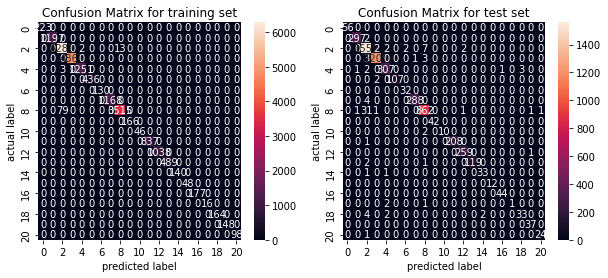

In [15]:
label = 'gl_legal_entity_id' # define label here
train_model(label, save_pkl=True)

In [ ]:
label = 'gl_vendor_id' # depth 5
train_model(label)

Reduced to 23189 samples from 768 relevant classes. (N=5)
Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,


In [ ]:
def train_model(label, save_pkl=False):
  x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df, label)

  XGB = XGBClassifier(random_state=42)
  parameters = {'n_estimators': [100],'max_depth':[3]}
  model = GridSearchCV(XGB, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=10)
  #model.get_params().keys()
  train_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl)

In [ ]:
label = 'gl_vendor_id' # depth 3
train_model(label)

## Prepare Data

In [16]:
# Prepare cost element column

df_kostenstelle = df[df['gl_cost_center_id'].notna()]
df_kostenstelle['Target'] = df_kostenstelle['gl_cost_center_id']

df_psp = df[df['gl_wbs_element_id'].notna()]
df_psp['Target'] = df_psp['gl_wbs_element_id']

df_auftrag = df[df['gl_order_id'].notna()]
df_auftrag['Target'] = df_auftrag['gl_order_id']

df_pka = pd.concat([df_auftrag,df_kostenstelle, df_psp], axis=0)
df_pka['Target'] = df_pka['Target'].apply(lambda x: str(x))

df_pka.dropna(subset=['text'], inplace=True)
df_pka.drop_duplicates(subset=['text'], inplace=True)

len(df_pka),len(df_pka['text'].unique())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

(31656, 31656)

In [17]:
with open("/content/retraining_october21/model.pkl", "rb") as file:
    clf_bukr = pkl.load(file)

## Train classifiers (always uses N=1 here)

In [18]:
local_min_num = 1

for company_code in clf_bukr.classes_:
    df_cost_elem = df_pka[df_pka["gl_legal_entity_id"] == company_code]
    num_classes = len(df_cost_elem["Target"].unique())
    print(f"company code {str(company_code).zfill(4)}: {len(df_cost_elem)} entries for {num_classes} classes")

company code 0037: 279 entries for 6 classes
company code 0065: 1721 entries for 174 classes
company code 0301: 7176 entries for 782 classes
company code 0303: 8809 entries for 1207 classes
company code 0330: 1605 entries for 107 classes
company code 0362: 563 entries for 36 classes
company code 0377: 173 entries for 23 classes
company code 0601: 2245 entries for 276 classes
company code 0801: 4789 entries for 568 classes
company code 0806: 229 entries for 20 classes
company code 0811: 53 entries for 10 classes
company code 0821: 1069 entries for 105 classes
company code 2101: 1321 entries for 137 classes
company code 2111: 624 entries for 57 classes
company code 3104: 172 entries for 21 classes
company code 3401: 62 entries for 1 classes
company code 3420: 279 entries for 20 classes
company code 9301: 23 entries for 9 classes
company code 9310: 187 entries for 61 classes
company code 9351: 168 entries for 21 classes
company code 9370: 104 entries for 18 classes


In [19]:
def train_com_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl):
    model.fit(X_train_vec, y_train)
    y_train_pred = model.predict(X_train_vec)
    y_test_pred = model.predict(X_test_vec)

    if save_pkl == True:
      pkl_path = "/content/retraining_october21/model.pkl"
      with open(pkl_path, "wb") as file:
        pkl.dump(model, file)

    print("Training Accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
    print("Test Accuracy: {:.3f}".format(accuracy_score(y_test, y_test_pred)))
    print(classification_report(y_test, y_test_pred))

In [20]:
def train_com_model(label, save_pkl=False):
  x_train, x_test, y_train, y_test, X_train_vec, X_test_vec = get_certain_class_after_vec_country(df_ce, label)
  model = XGBClassifier(max_depth=5, random_state=42)
  train_com_statistical_model(model, X_train_vec, y_train, X_test_vec, y_test, save_pkl)

In [21]:
for company_code in clf_bukr.classes_:
    print(f"Company Code: {str(company_code).zfill(4)}" + "\n")
    # reduce dataframe to entries for fixed company code
    df_cost_elem = df_pka[df_pka["gl_legal_entity_id"] == company_code]
    
    print("Cost Element classification:")
    # reduce to relevant samples
    df_ce = reduce_to_relevant(df_cost_elem, "Target", min_num_samples=local_min_num)
    
    if df_ce.shape[0] == 0:  # do not proceed if df is empty
        print(20 * "-" + "\n")
        continue
    train_com_model('Target')
    
    print(20 * "-" + "\n")

Company Code: 0037

Cost Element classification:
Reduced to 279 samples from 6 relevant classes. (N=1)
Reduced to 271 samples from 2 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.982
              precision    recall  f1-score   support

  0000037001       1.00      0.98      0.99        52
  0000037330       0.75      1.00      0.86         3

    accuracy                           0.98        55
   macro avg       0.88      0.99      0.92        55
weighted avg       0.99      0.98      0.98        55

--------------------

Company Code: 0065

Cost Element classification:
Reduced to 1721 samples from 174 relevant classes. (N=1)
Reduced to 1498 samples from 37 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.860
                          precision    recall  f1-score   support

0065.1206O3.201.00.10.03       1.00      0.80      0.89        10
0065.1206O3.201.00.10.06       1.00      1.00      1.00         2
0065.1206OA.203.00.10.02       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 7176 samples from 782 relevant classes. (N=1)
Reduced to 6173 samples from 238 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.797
                          precision    recall  f1-score   support

              0010100902       0.89      0.96      0.93        26
              0010100950       0.00      0.00      0.00         1
              0011100810       0.67      0.67      0.67         3
              0012000163       1.00      1.00      1.00        10
              0012000355       0.00      0.00      0.00         4
              0012000580       1.00      1.00      1.00         1
              0012000591       0.00      0.00      0.00         1
              0012000603       1.00      1.00      1.00         2
              0012006201       1.00      0.50      0.67         2
              0022100133       0.50      1.00      0.67         1
              0028000020       0.50      0.50      0.50         4
              0028000050       0.38      0.38  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 8809 samples from 1207 relevant classes. (N=1)
Reduced to 7314 samples from 350 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.768
                    precision    recall  f1-score   support

        0110110000       0.71      0.80      0.75        15
        0110510000       0.58      0.88      0.70         8
        0111510000       1.00      0.75      0.86         4
        0112010000       0.85      0.85      0.85        13
        0112510000       0.79      0.79      0.79        14
        0114010000       1.00      0.50      0.67         2
        0121014000       0.71      0.83      0.77         6
        0121515000       0.83      0.83      0.83         6
        0121520500       1.00      1.00      1.00         1
        0122010000       0.83      0.71      0.77        21
        0122015000       1.00      1.00      1.00         1
        0122015200       0.00      0.00      0.00         2
        0122015300       0.82      0.75      0.78        1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 1501 samples from 61 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.821
                       precision    recall  f1-score   support

   0330.Y12100.004.02       1.00      1.00      1.00         1
   0330.Y12100.004.03       0.80      1.00      0.89         4
   0330.Y12100.004.05       1.00      1.00      1.00         1
   0330.Y12100.004.08       1.00      1.00      1.00         3
   0330.Y12100.004.12       1.00      0.80      0.89         5
   0330.Y12100.004.16       1.00      0.50      0.67         2
   0330.Y12100.004.19       0.00      0.00      0.00         1
   0330.Y12100.004.20       0.50      0.50      0.50         2
      0330.Y12100.005       0.88      0.58      0.70        12
   0330.Y12100.008.01       0.50      1.00      0.67         1
   0330.Y12210.009.01       1.00      1.00      1.00         1
   0330.Y12210.009.02       1.00      1.00      1.00         2
      0330.Y12210.111       1.00      0.33      0.50         3
0330.Y12807.001

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.838
                    precision    recall  f1-score   support

        0015030020       1.00      0.67      0.80         3
        0015030030       0.00      0.00      0.00         3
        0015030050       0.73      0.90      0.81        30
        0015030065       0.50      0.25      0.33         4
        0015030070       1.00      1.00      1.00         1
        0015076001       1.00      0.50      0.67         4
        0015097101       0.00      0.00      0.00         2
        0015098103       0.82      0.90      0.86        10
0362.G62000.088.55       0.60      0.75      0.67         4
0362.G62000.092.58       1.00      1.00      1.00         2
0362.G62000.093.58       1.00      1.00      1.00         1
0362.G62000.095.01       1.00      1.00      1.00         1
0362.G62000.096.58       1.00      1.00      1.00        28
0362.G62000.999.30       1.00      0.80      0.89         5
0362.G63000.082.55       1.00      1.00      1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.710
                       precision    recall  f1-score   support

           0077025030       1.00      1.00      1.00         1
           0077030010       1.00      1.00      1.00         3
           0077080122       0.50      0.50      0.50         6
           0077100231       1.00      1.00      1.00         2
   0377.G77000.072.65       1.00      0.40      0.57         5
   0377.G77000.073.59       0.60      1.00      0.75         3
   0377.G77000.096.56       0.50      1.00      0.67         3
   0377.G77000.999.55       0.67      0.40      0.50         5
0377.O77952.005.14.02       1.00      1.00      1.00         1
      0377.W77305.005       1.00      1.00      1.00         2

             accuracy                           0.71        31
            macro avg       0.83      0.83      0.80        31
         weighted avg       0.76      0.71      0.70        31

--------------------

Company Code: 0601

Cost Element classification

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 4789 samples from 568 relevant classes. (N=1)
Reduced to 4015 samples from 163 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.767
                       precision    recall  f1-score   support

           0000010240       0.00      0.00      0.00         1
           0000011440       0.50      1.00      0.67         1
           0000012140       0.50      1.00      0.67         1
           0000018010       0.75      1.00      0.86         3
           0000040340       0.00      0.00      0.00         2
           0000040440       0.50      1.00      0.67         1
           0000040540       0.00      0.00      0.00         1
           0000041340       1.00      1.00      1.00         1
           0000041640       0.00      0.00      0.00         1
           0000042040       0.20      0.33      0.25         3
           0000042240       0.00      0.00      0.00         1
           0000045841       0.00      0.00      0.00         1
           000004701

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.805
                 precision    recall  f1-score   support

     0000068000       0.89      0.92      0.91        26
     0000068100       1.00      1.00      1.00         2
     0000069000       0.75      0.60      0.67         5
0806.A68009.950       0.50      1.00      0.67         1
0806.S60000.010       0.50      0.50      0.50         2
0806.S60000.500       0.00      0.00      0.00         1
0806.S60000.800       0.67      0.67      0.67         3
0806.S61016.990       0.00      0.00      0.00         1

       accuracy                           0.80        41
      macro avg       0.54      0.59      0.55        41
   weighted avg       0.79      0.80      0.79        41

--------------------

Company Code: 0811

Cost Element classification:
Reduced to 53 samples from 10 relevant classes. (N=1)
Reduced to 36 samples from 3 relevant classes. (N=5)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.750
                 precision    recall  f1-score   support

     0000010111       1.00      0.33      0.50         3
     0000010511       0.60      1.00      0.75         3
0811.C95002.105       1.00      1.00      1.00         2

       accuracy                           0.75         8
      macro avg       0.87      0.78      0.75         8
   weighted avg       0.85      0.75      0.72         8

--------------------

Company Code: 0821

Cost Element classification:
Reduced to 1069 samples from 105 relevant classes. (N=1)
Reduced to 972 samples from 50 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.903
                 precision    recall  f1-score   support

     0000010721       1.00      0.50      0.67         2
     0000010921       0.67      0.67      0.67         3
     0000011421       1.00      1.00      1.00         1
     0000050221       0.00      0.00      0.00         1
     0000050321       0.67      1.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.741
                       precision    recall  f1-score   support

           0000001000       0.67      0.80      0.73         5
           0000002000       0.40      0.25      0.31         8
           0000002004       0.73      0.69      0.71        16
           0000002200       1.00      1.00      1.00         2
           0000002401       0.62      0.62      0.62         8
           0000002404       0.00      0.00      0.00         1
           0000002502       0.60      0.60      0.60         5
           0000003000       1.00      0.75      0.86        12
           0000005100       1.00      0.25      0.40         4
           0000005101       1.00      0.33      0.50         3
           0000005206       1.00      0.25      0.40         4
           0000006102       1.00      0.71      0.83         7
           0000006104       0.00      0.00      0.00         4
           0000006106       0.70      0.88      0.78         8
        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.829
                 precision    recall  f1-score   support

     0000007100       0.83      0.98      0.90        54
     0000007111       0.50      1.00      0.67         1
     0000007112       0.00      0.00      0.00         1
     0000007114       0.00      0.00      0.00         2
     0000007116       0.00      0.00      0.00         1
     0000007156       0.00      0.00      0.00         2
     0000007160       1.00      0.50      0.67         2
     0000007175       0.83      0.94      0.88        16
     0000007800       0.00      0.00      0.00         3
2111.C02006.001       1.00      1.00      1.00         3
2111.C40073.001       0.00      0.00      0.00         2
2111.C50121.001       1.00      1.00      1.00         2
2111.C60074.001       0.00      0.00      0.00         2
2111.C70055.001       1.00      1.00      1.00         1
2111.C80015.001       0.00      0.00      0.00         1
2111.C80028.001       1.00      0.83     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.613
              precision    recall  f1-score   support

  3104C20000       0.60      0.75      0.67         4
  3104C21000       0.29      0.40      0.33         5
  3104C22000       0.89      0.80      0.84        10
  3104C23000       0.00      0.00      0.00         3
  3104C53000       1.00      1.00      1.00         1
  3104C55200       1.00      1.00      1.00         1
  3104C56000       0.00      0.00      0.00         1
 802909914.0       1.00      0.50      0.67         2
 802909920.0       0.67      1.00      0.80         2
 802909926.0       0.33      0.50      0.40         2

    accuracy                           0.61        31
   macro avg       0.58      0.59      0.57        31
weighted avg       0.60      0.61      0.60        31

--------------------

Company Code: 3401

Cost Element classification:
Reduced to 62 samples from 1 relevant classes. (N=1)
Reduced to 62 samples from 1 relevant classes. (N=5)
Training Accuracy:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reduced to 254 samples from 7 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.745
              precision    recall  f1-score   support

  3420C10000       0.82      0.75      0.78        12
 802000424.0       1.00      0.50      0.67         8
 802000425.0       1.00      1.00      1.00         2
 802000426.0       0.67      1.00      0.80        10
 802015306.0       0.82      0.82      0.82        11
 802015320.0       0.43      0.43      0.43         7
 802015324.0       1.00      1.00      1.00         1

    accuracy                           0.75        51
   macro avg       0.82      0.79      0.79        51
weighted avg       0.77      0.75      0.74        51

--------------------

Company Code: 9301

Cost Element classification:
Reduced to 23 samples from 9 relevant classes. (N=1)
Reduced to 13 samples from 2 relevant classes. (N=5)
Training Accuracy: 1.000
Test Accuracy: 0.667
              precision    recall  f1-score   support

  0077020010       0.50  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.839
              precision    recall  f1-score   support

  2935114006       1.00      1.00      1.00         3
  2935116100       0.86      0.75      0.80         8
  2935116200       0.67      1.00      0.80         2
  2935116210       0.50      0.50      0.50         2
  2935116230       1.00      1.00      1.00         1
  2935116410       1.00      1.00      1.00         1
  2935116910       0.00      0.00      0.00         2
  2935116920       1.00      1.00      1.00         2
  2935158005       0.50      1.00      0.67         2
  2935158008       1.00      1.00      1.00         1
  2935158010       1.00      1.00      1.00         3
  2935158012       1.00      1.00      1.00         2
  2935158016       1.00      1.00      1.00         1
  2935158020       1.00      1.00      1.00         1

    accuracy                           0.84        31
   macro avg       0.82      0.88      0.84        31
weighted avg       0.81      0.84 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 1.000
Test Accuracy: 0.889
              precision    recall  f1-score   support

  2937030000       1.00      1.00      1.00         2
  2937033400       1.00      1.00      1.00         3
  2937039200       1.00      1.00      1.00         1
  2937052000       0.83      1.00      0.91         5
  2937053000       1.00      0.50      0.67         2
  2937059000       1.00      1.00      1.00         2
  2937060000       0.67      0.67      0.67         3

    accuracy                           0.89        18
   macro avg       0.93      0.88      0.89        18
weighted avg       0.90      0.89      0.88        18

--------------------

